In [411]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley.kriging import KrigingIndices, janon_estimator, compute_indice, compute_indices, create_indices_df
from shapley.tests.test_functions import ishigami, ot_ishigami, ishigami_true_indices
from shapley.plots import set_style_paper, violin_plot_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [412]:
dim = 3
model = ishigami
ot_model = ot.PythonFunction(dim, 1, ot_ishigami)
margins = [ot.Uniform(-np.pi, np.pi)]*dim
copula = ot.IndependentCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)

## Sobol indices with MC

In [413]:
max_budget = 200
n_sample = int(max_budget/(2*dim))
n_boot = 1000

ot.RandomGenerator.SetSeed(0)
input_sample_1 = np.asarray(input_distribution.getSample(n_sample))
input_sample_2 = np.asarray(input_distribution.getSample(n_sample))

In [52]:
first_indices_mc = compute_indices(model, input_sample_1, input_sample_2, n_boot=n_boot)

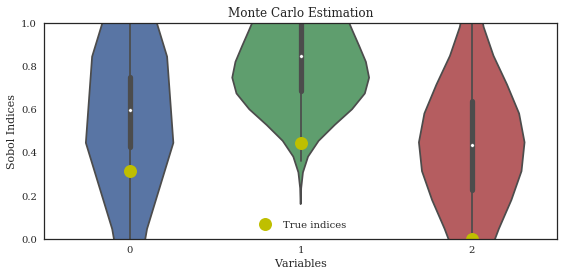

In [281]:
violin_plot_indices(first_indices_mc.T, true_indices=ishigami_true_indices, title="Monte Carlo Estimation", xlim=[0, 1])

## Sobol indices with kriging
We keep the same budget as previously

In [414]:
%%time
n_sample_kriging = max_budget
kriging = KrigingIndices(ot_model, input_distribution)
kriging.build_model(n_sample_kriging=n_sample_kriging)

Wall time: 287 ms


In [415]:
%%time
n_realization = 500
n_boot = 1000
n_sample_mc = 200
first_indices = kriging.compute_indices(n_sample=n_sample_mc, n_realization=n_realization, n_boot=n_boot)

Wall time: 9.57 s


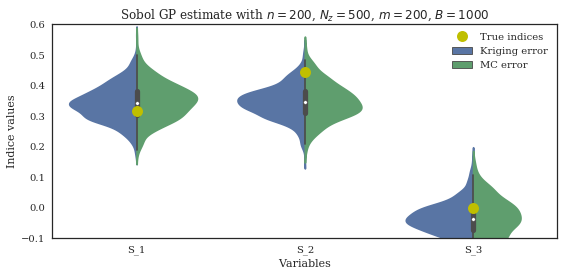

In [416]:
title = 'Sobol GP estimate with $n=%d$, $N_z=%d$, $m=%d$, $B=%d$' % (n_sample_kriging, n_realization, n_sample_mc, n_boot)
ylim = [-0.1, .6]

df = create_df(first_indices)

fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='Variables', y='Indice values', data=df, hue='Error', ax=ax, 
               label='First order indices', split=True, gridsize=500)
ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
ax.set_title(title)
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()
fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.pdf' % (n_sample_kriging, n_realization, n_sample_mc, n_boot))
fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.png' % (n_sample_kriging, n_realization, n_sample_mc, n_boot))

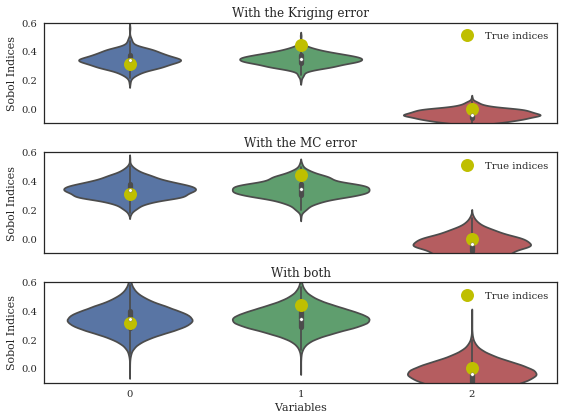

In [424]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 6))
violin_plot_indices(first_indices.mean(axis=2).T, true_indices=ishigami_true_indices, title="With the Kriging error", ylim=ylim, ax=axes[0])
violin_plot_indices(first_indices.mean(axis=1).T, true_indices=ishigami_true_indices, title="With the MC error", ylim=ylim, ax=axes[1])
violin_plot_indices(first_indices.reshape(dim, -1).T, true_indices=ishigami_true_indices, title="With both", xlabel='Variables', ylim=ylim, ax=axes[2])
fig.tight_layout()

In [278]:
var_MC = first_indices.std(axis=2).mean(axis=1)
var_MC

array([ 0.02960777,  0.031252  ,  0.04535493])

In [279]:
var_kriging = first_indices.std(axis=1).mean(axis=1)
var_kriging

array([ 0.00674435,  0.00756327,  0.00684583])

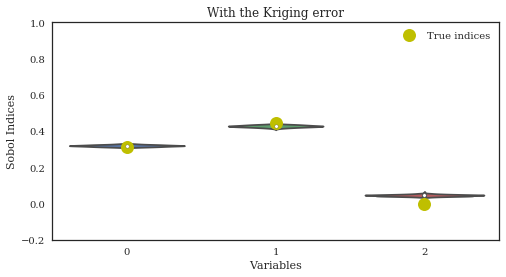

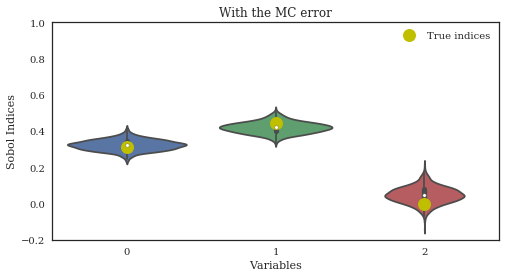

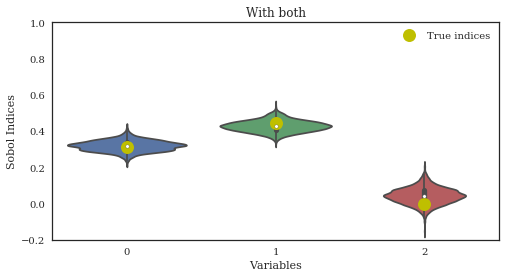

In [347]:
violin_plot_indices(first_indices[:, :, 0].T, true_indices=ishigami_true_indices, title="With the Kriging error", xlim=[-0.2, 1])
violin_plot_indices(first_indices[:, 0, :].T, true_indices=ishigami_true_indices, title="With the MC error", xlim=[-0.2, 1])
violin_plot_indices(first_indices.reshape(dim, -1).T, true_indices=ishigami_true_indices, title="With both", xlim=[-0.2, 1])